# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 10</span>

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 11 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 11, is characterized by a different temperature or a limited set of temperatures (if you need more than 11 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

## CHOICE 1:
The exercise remains the same as in exercise 9, so the program structure is the same. For reference, you can consult the notebook from `Lezione 9`. This applies to exercise `10.2` as well.

## Introduction to Parallelization
The exercise requires parallelizing the genetic algorithm exercise using the MPI (Message Passing Interface) library, which is a standard developed by the Message Passing Interface Forum (MPIF).

Below, I will show the updates implemented in the code step by step as we proceed in the main function.

- Initialization and access to rank and size information:
```cpp
  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &size); // Get the total number of processes
  MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Get the rank of each process
```
Initialization is necessary to set up the MPI environment and to create the MPI processes. The other two calls, `MPI_Comm_size(MPI_COMM_WORLD, &size)` and `MPI_Comm_rank(MPI_COMM_WORLD, &rank)`, are needed to access the *size*, which refers to the number of cores used in the program (5 in this exercise), and to access the *rank*, which is the number associated with each individual processor.`MPI_COMM_WORLD` is a command to indicate all the rank involved in the programm.

To prevent the processors from generating the same pseudorandom numbers, it became necessary to modify the initialization of the `random_generator()` by imposing a different `Primer` based on the rank, while keeping the seed unchanged.

Below is a part of the `initialize` function belonging to the `tsp` class, demonstrating this:


```cpp
    void tsp :: initialize(int rank){     //function to initialize the system: shape and other parameters
        int p1, p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12; // Read from ./INPUT/Primes a pair of numbers to be used to initialize the RNG
        ifstream Primes("./INPUT/Primes");
        string line;
        if (rank == 0){                   //parallelized the lecture of Primes
        Primes >> p1 >> p2 ;
        }
        if (rank == 1){ 
        getline(Primes,line);                
        Primes >> p3 >> p4 ;
        }
        if (rank == 2){
        getline(Primes,line);    
        getline(Primes,line);    
        Primes >> p5 >> p6 ;
        }
        if (rank == 3){
        getline(Primes,line);    
        getline(Primes,line);    
        getline(Primes,line);    
        Primes >> p7 >> p8 ;
        }
        if (rank == 4){
        getline(Primes,line);    
        getline(Primes,line);    
        getline(Primes,line);    
        getline(Primes,line);    
        Primes >> p9 >> p10 ;
        }
        if (rank == 5){
        getline(Primes,line);    
        getline(Primes,line);    
        getline(Primes,line);    
        getline(Primes,line);    
        getline(Primes,line);    
        Primes >> p11 >> p12 ;
        }
        Primes.close();  

        [...same as Exercise_9...]

```








## Migration
The exercise also requires that during the GA process, a migration process is introduced every `N_migr` generations. Here, each core sends its best gene with the lowest loss function to another core and exchanges it with the best gene received from another core. It’s not necessary for there to be a direct swap of genes between corresponding cores; however, to implement this, it is essential to determine which core sends to which.

At the beginning, random pairs are chosen by collecting the rank numbers into a vector, which is then shuffled. This shuffled vector is distributed across all processes using `MPI_Bcast` to ensure alignment.

```cpp
if (rank == 0) {
    rank_n_copy = arma::shuffle(rank_n); // Shuffle ranks only in process 0
}
MPI_Bcast(rank_n_copy.memptr(), rank_n_copy.n_elem, MPI_DOUBLE, 0, MPI_COMM_WORLD); // Broadcast shuffled ranks to all processes
```
If the shuffle process had been conducted on each rank, compatibility would be lost regarding the target rank for each message.
Once the target core for gene exchange is chosen, the migration code section is as follows:

```cpp
if (N_Migr != 0 && (i + 1) % N_Migr == 0) { 
    MPI_Barrier(MPI_COMM_WORLD); // Synchronize before migration

    vec L_V = TSP.Loss_vector(TSP.get_mat_pop()); // Get loss values for current population
    int idx = TSP.Loss_best_idx(L_V); // Get index of best individual

    arma::vec temp_vec = (TSP.get_mat_pop()).row(idx).t(); // Get best individual (row vector)
    arma::vec temp_vec_copy = temp_vec; // Copy of the best individual

    MPI_Send(temp_vec.memptr(), temp_vec.n_elem, MPI_DOUBLE, rank_n_copy[rank], rank, MPI_COMM_WORLD); // Send best individual to target rank
    MPI_Barrier(MPI_COMM_WORLD); // Synchronize after sending

    int sender_rank = TSP.find_sender_idk(rank, rank_n_copy); // Find rank that sends data
    MPI_Recv(temp_vec_copy.memptr(), temp_vec.n_elem, MPI_DOUBLE, sender_rank, sender_rank, MPI_COMM_WORLD, MPI_STATUS_IGNORE); // Receive best individual from sender rank
    MPI_Barrier(MPI_COMM_WORLD);

    TSP.set_row_pop(temp_vec_copy, idx); // Update population with received individual
    MPI_Barrier(MPI_COMM_WORLD); // Final synchronization after migration
}

```

where in this part of code I use:
- `MPI_Barrier` to syncronise the rank process,
- `MPI_Send` to permit to a core to send a row matrix vector to another core;
- `MPI_Receive` to enable a core to receive a particular element from another core.

Afterwards, the final output includes an additional function where `MPI_Reduce` and `MPI_Allgather` are used to calculate the minimum loss values across all cores (determining the best path) and to gather this information. This data is saved in files named `./Esercizio_10_1/OUTPUT/best_path_circunference_{n}_.dat` or `./Esercizio_10_1/OUTPUT/best_path_square_{n}_.dat` and for loss function 
`./Esercizio_10_1/OUTPUT/Loss_media_circunference_best_{n}_.dat` and `./Esercizio_10_1/OUTPUT/Loss_media_square_best_{n}_.dat` where `n` is the number of the core.

At the end of the exercise, MPI_Finalize is used to complete and finalize the program.

## Data Obtained:
Below, I present the data obtained with migration for cities positioned on a circumference and inside a square. In this exercise the analysis is doing on `5 CORES`

### Cities on a Circumference:
Setting `N_migr = 45` and a population size of `100` for the circumference case with `350` generation, with $\alpha = 15.899$ and setting the `mutation` probability at $4.5\%$ and the `cross-over` probability at $81\%$ as in Exercise 9.



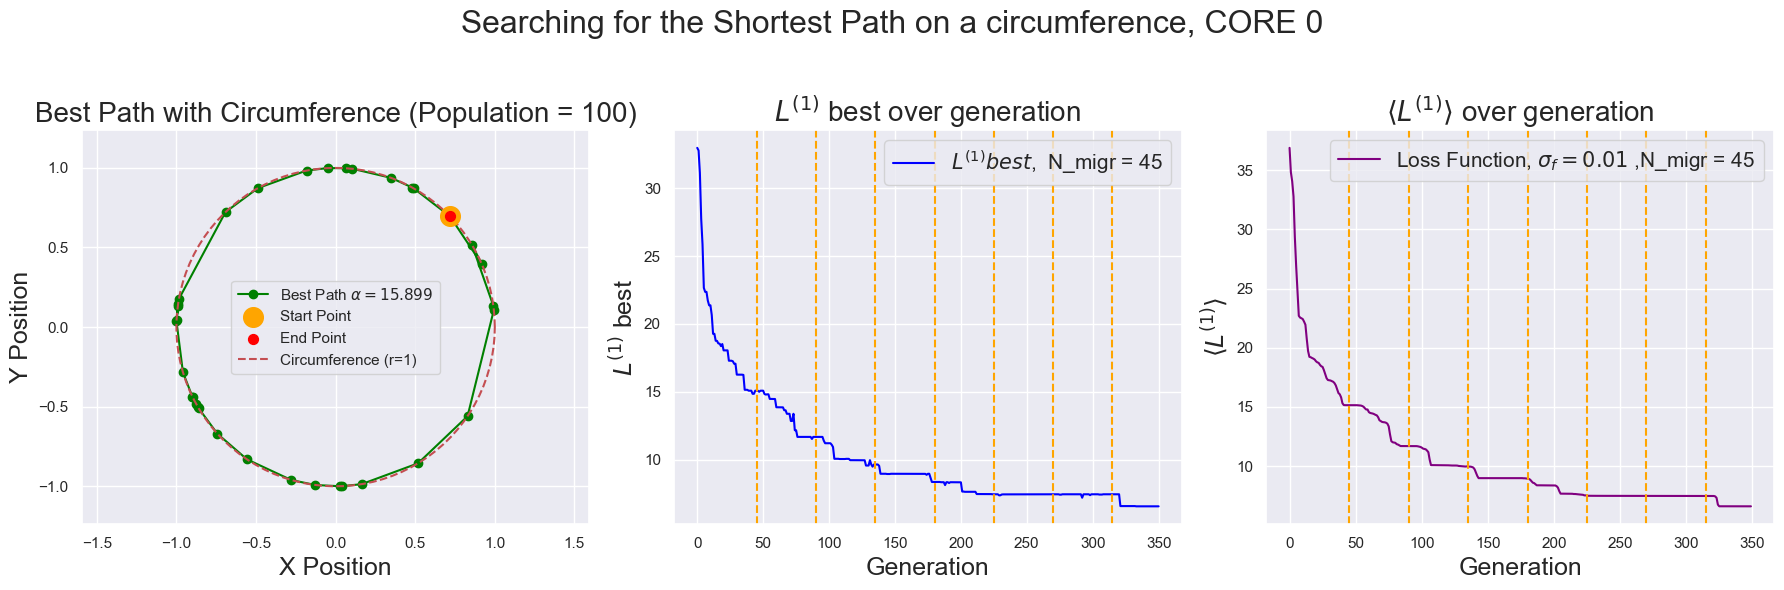

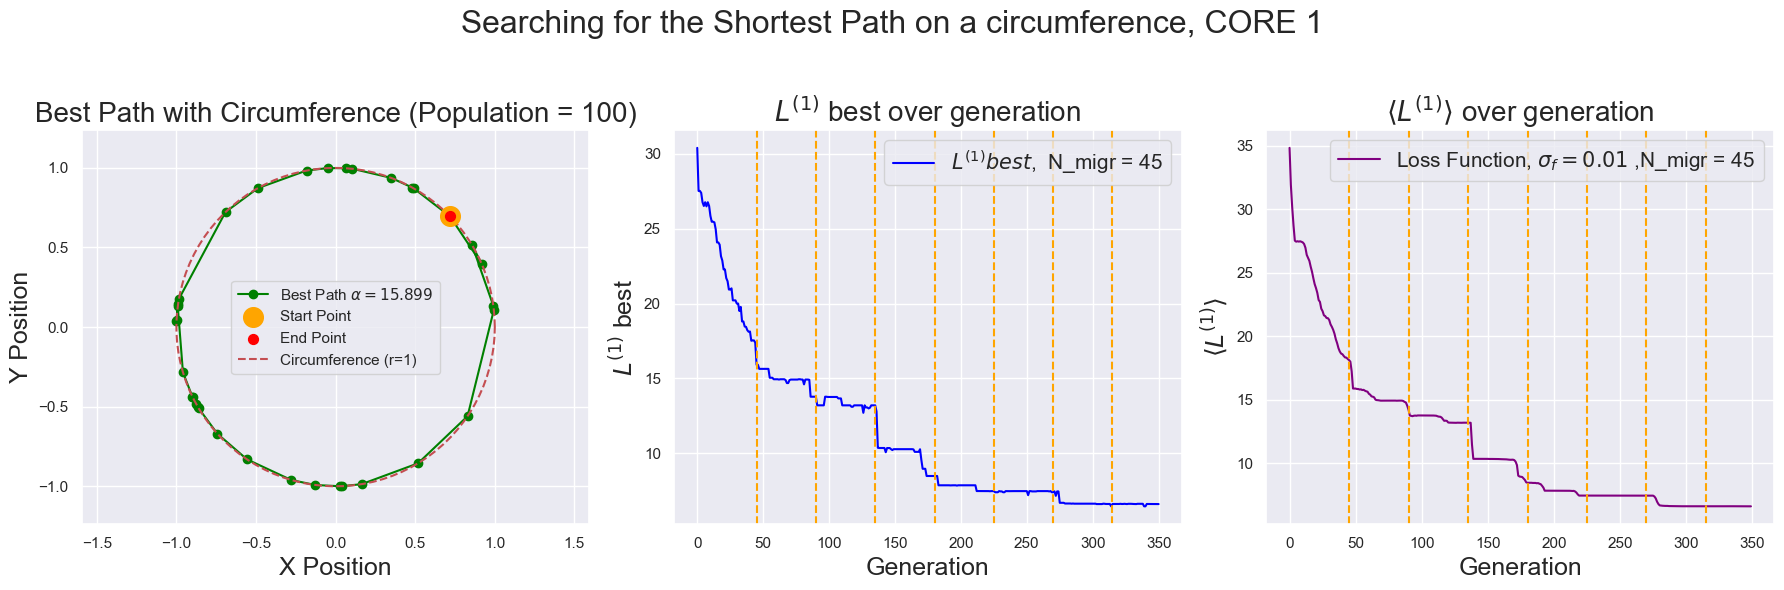

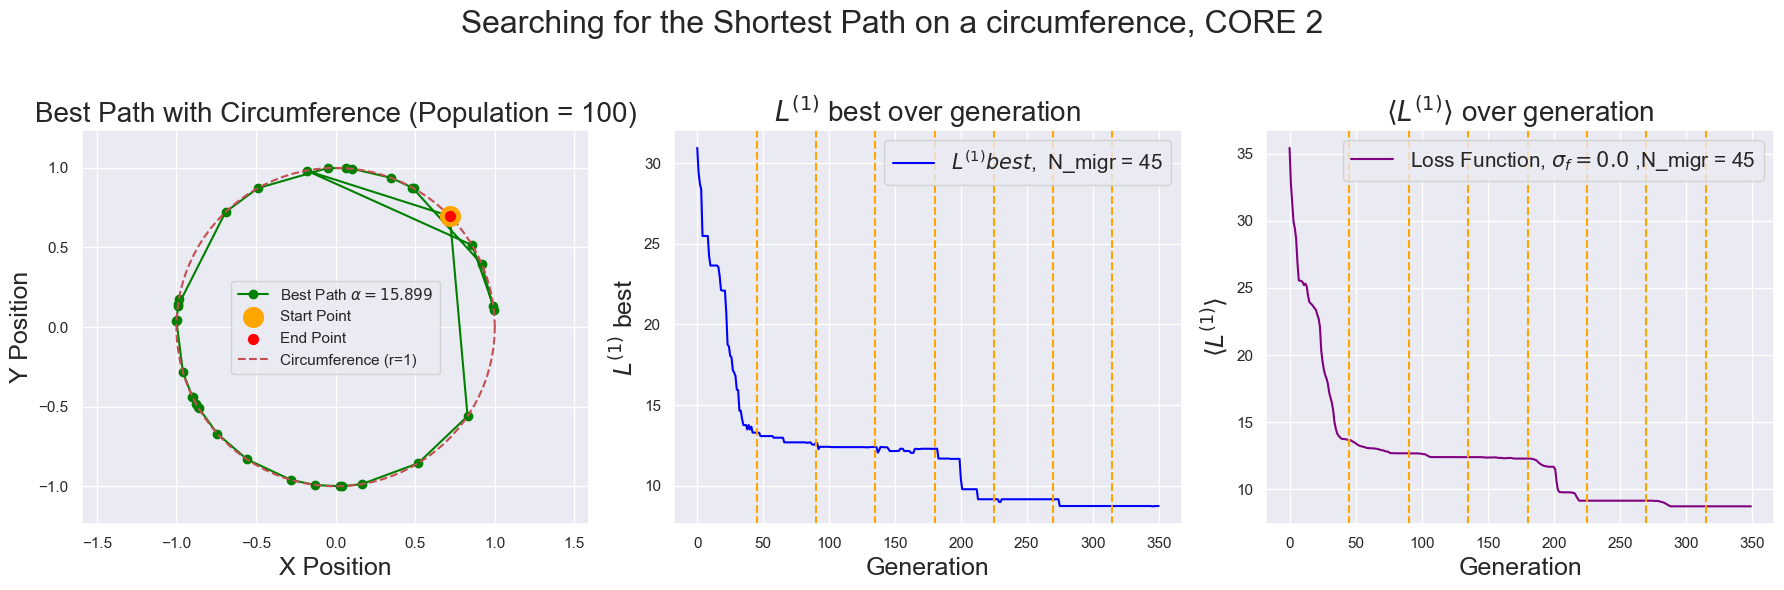

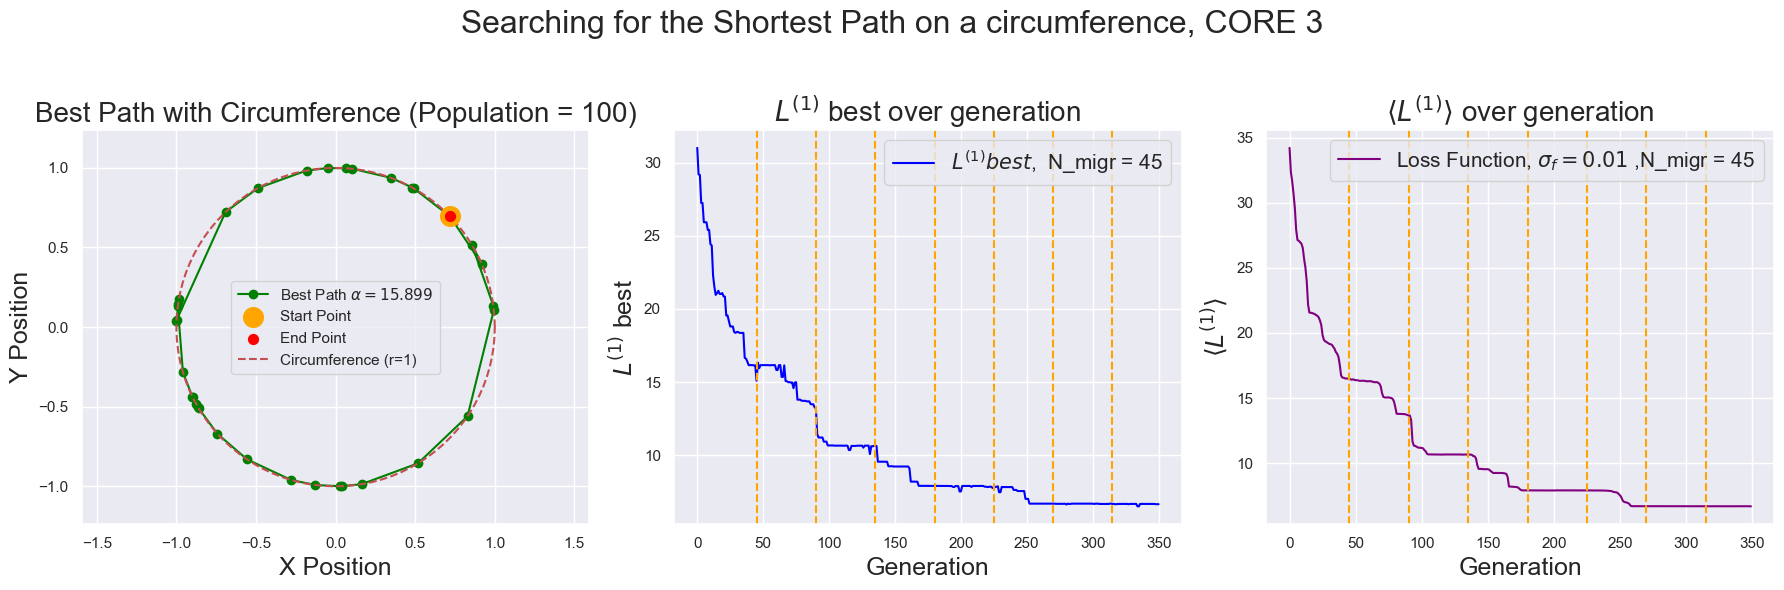

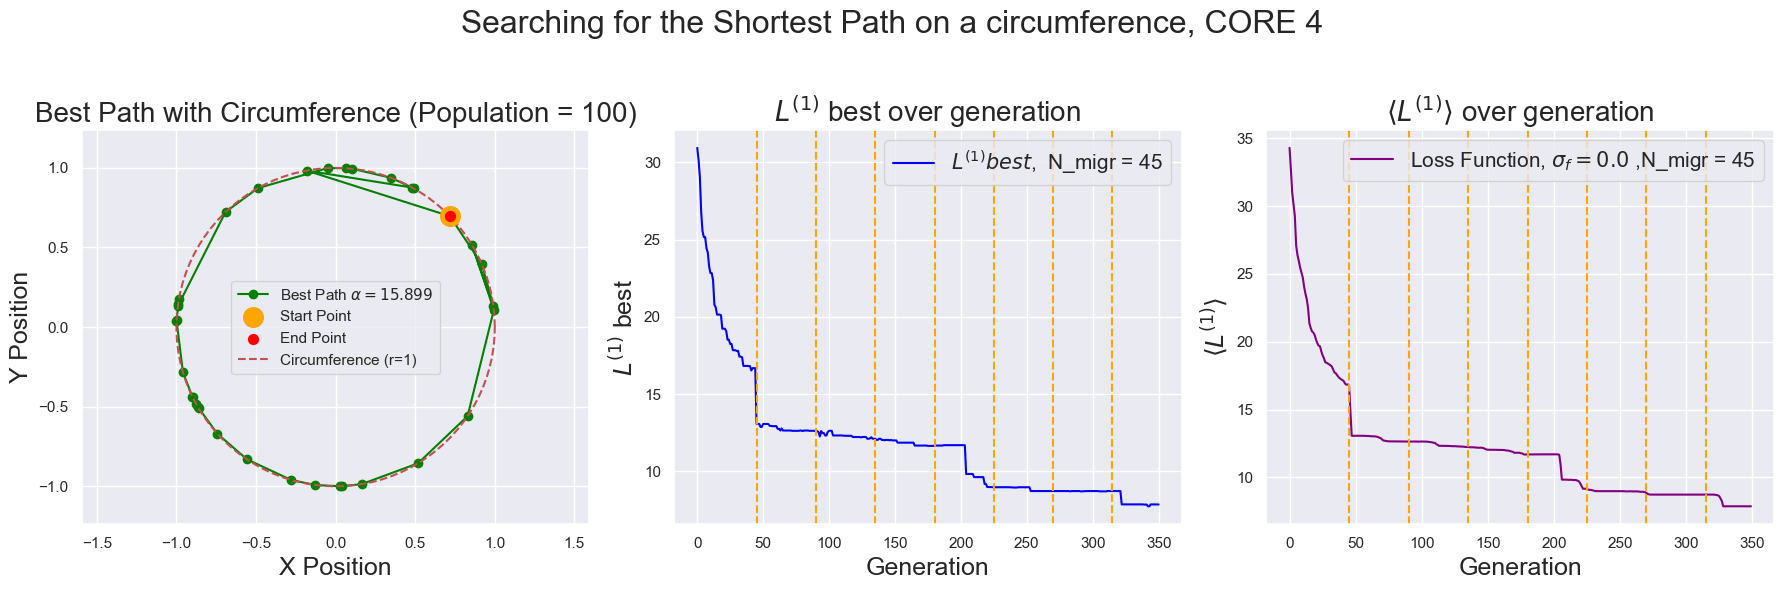

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual theme for the plots
sns.set_theme(style='darkgrid')

# Loop over n from 0 to 4
for n in range(5):
    # 1. Load the path data for the current core
    file_path_path = f'./Esercizio_10_1/OUTPUT/best_path_circunference_{n}_.dat'
    data_path = np.loadtxt(file_path_path, skiprows=1)
    x_positions = data_path[:, 0]
    y_positions = data_path[:, 1]

    # 2. Load the loss function data for the current core
    file_path_loss = f'./Esercizio_10_1/OUTPUT/Loss_media_circunference_best_{n}_.dat'
    data_loss = np.loadtxt(file_path_loss, skiprows=1)

    # Separate the columns: first column for plotting, last value of the second column for dev_std_best
    loss_values = data_loss[:, 0]  # Take only the first column for plotting
    dev_std_best = data_loss[-1, 1]  # Take the last value of the second column

    # 3. Load the additional single loss data for the current core
    file_path_loss_single = f'./Esercizio_10_1/OUTPUT/Loss_media_circunference_best_{n}_single.dat'
    loss_single_values = np.loadtxt(file_path_loss_single, skiprows=1)

    # 4. Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Searching for the Shortest Path on a circumference, CORE {n}", fontsize=23)

    # 4.1. Plot the path with the circumference
    axs[0].plot(x_positions, y_positions, marker='o', linestyle='-', color='green', label=r'Best Path $\alpha = 15.899 $')
    axs[0].scatter(x_positions[0], y_positions[0], color='orange', s=200, zorder=5, label='Start Point')
    axs[0].scatter(x_positions[-1], y_positions[-1], color='red', s=50, zorder=5, label='End Point')

    # Draw the circumference of radius 1
    raggio = 1
    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = raggio * np.cos(theta)
    y_circle = raggio * np.sin(theta)
    axs[0].plot(x_circle, y_circle, color='r', linestyle='--', label='Circumference (r=1)')

    # Customizations for the first subplot
    axs[0].set_title("Best Path with Circumference (Population = 100)", fontsize=20)
    axs[0].set_xlabel("X Position", fontsize=18)
    axs[0].set_ylabel("Y Position", fontsize=18)
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    # 4.2. Plot the original loss function
    axs[2].plot(loss_values, color='purple', label=f'Loss Function, $\sigma_f = {np.round(dev_std_best,2)}$ ,N_migr = 45')

    # Customizations for the second subplot
    axs[2].set_title(r"$\langle L^{(1)} \rangle$ over generation", fontsize=20)
    axs[2].set_xlabel("Generation", fontsize=18)
    axs[2].set_ylabel(r"$\langle L^{(1)} \rangle$", fontsize=18)
    axs[2].legend(fontsize=15)
    axs[2].grid(True)

    # Add vertical dashed lines for multiples of 45
    for generation in range(45, len(loss_values), 45):
        axs[2].axvline(x=generation, color='orange', linestyle='--')

    

    # 4.3. Plot the single loss function
    axs[1].plot(loss_single_values, color='blue', label=r'$L^{(1)} best$,  N_migr = 45')
    axs[1].set_title(r"$L^{(1)}$ best over generation", fontsize=20)
    axs[1].set_xlabel("Generation", fontsize=18)
    axs[1].set_ylabel(r"$L^{(1)}$ best", fontsize=18)
    axs[1].legend(fontsize=15)
    axs[1].grid(True)

    # Add vertical dashed lines for multiples of 45
    for generation in range(45, len(loss_values), 45):
        axs[1].axvline(x=generation, color='orange', linestyle='--')

    # Display the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the global title
    plt.show()


### Cities in a Square:
Setting `N_migr = 40` and a population size of `400` for the square case with `300` generation, with $\alpha = 8$ and setting the `mutation` probability at $4.5\%$ and the `cross-over` probability at $81 \%$ as in Exercise 9.

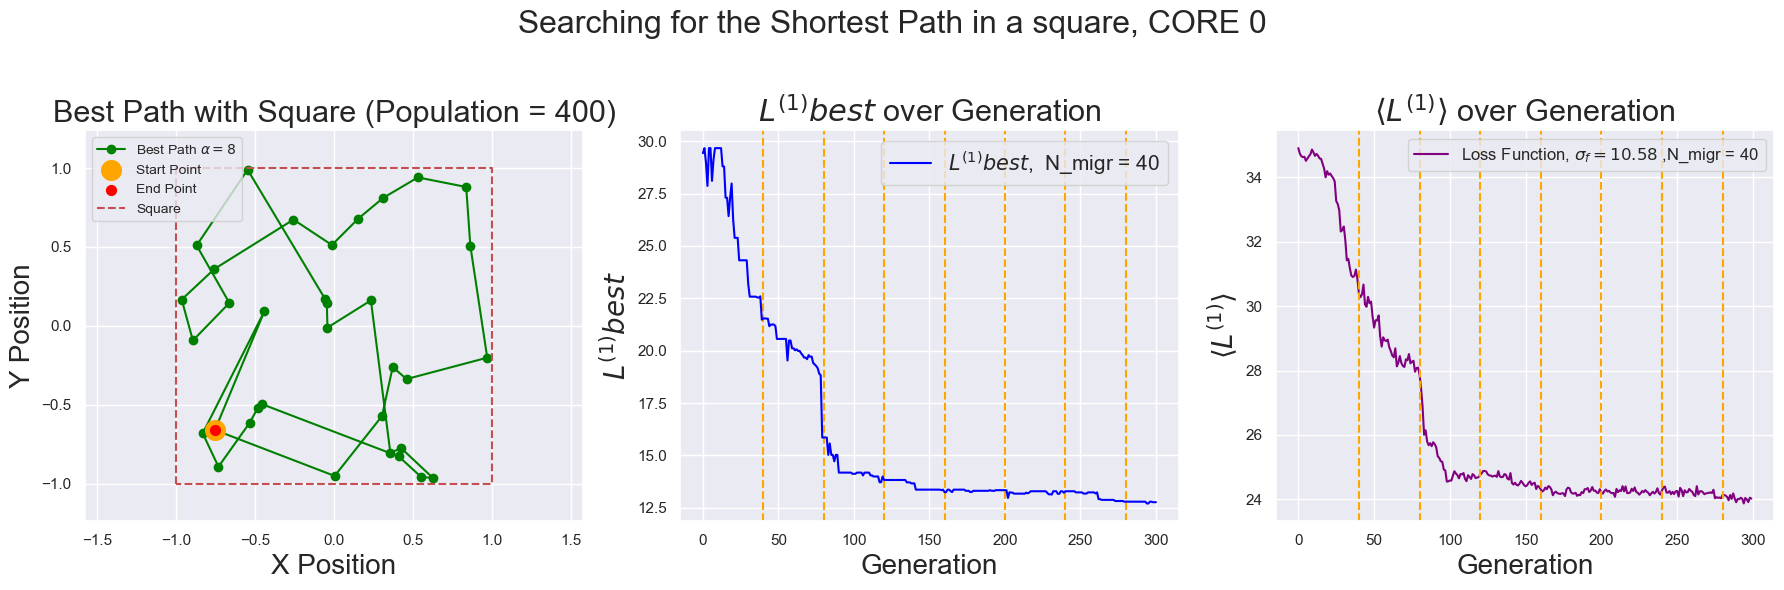

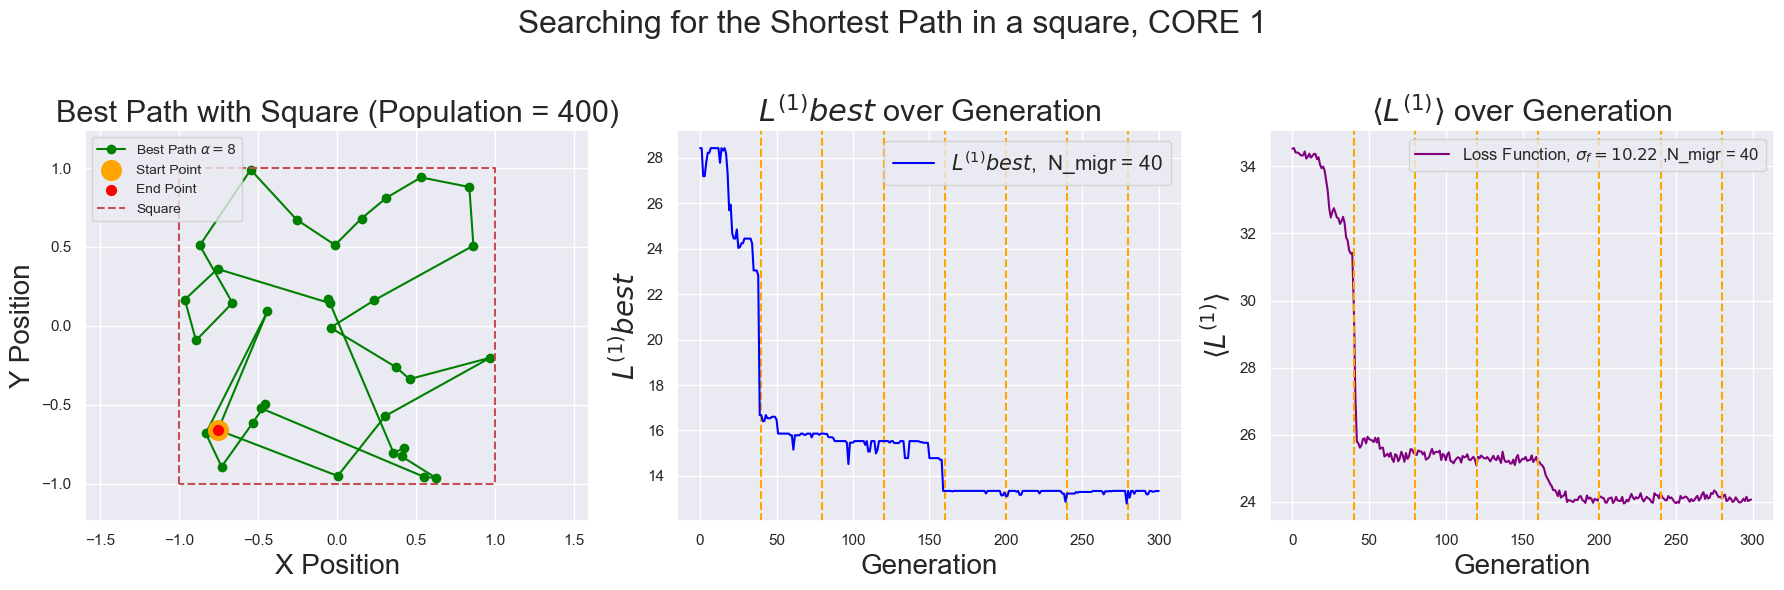

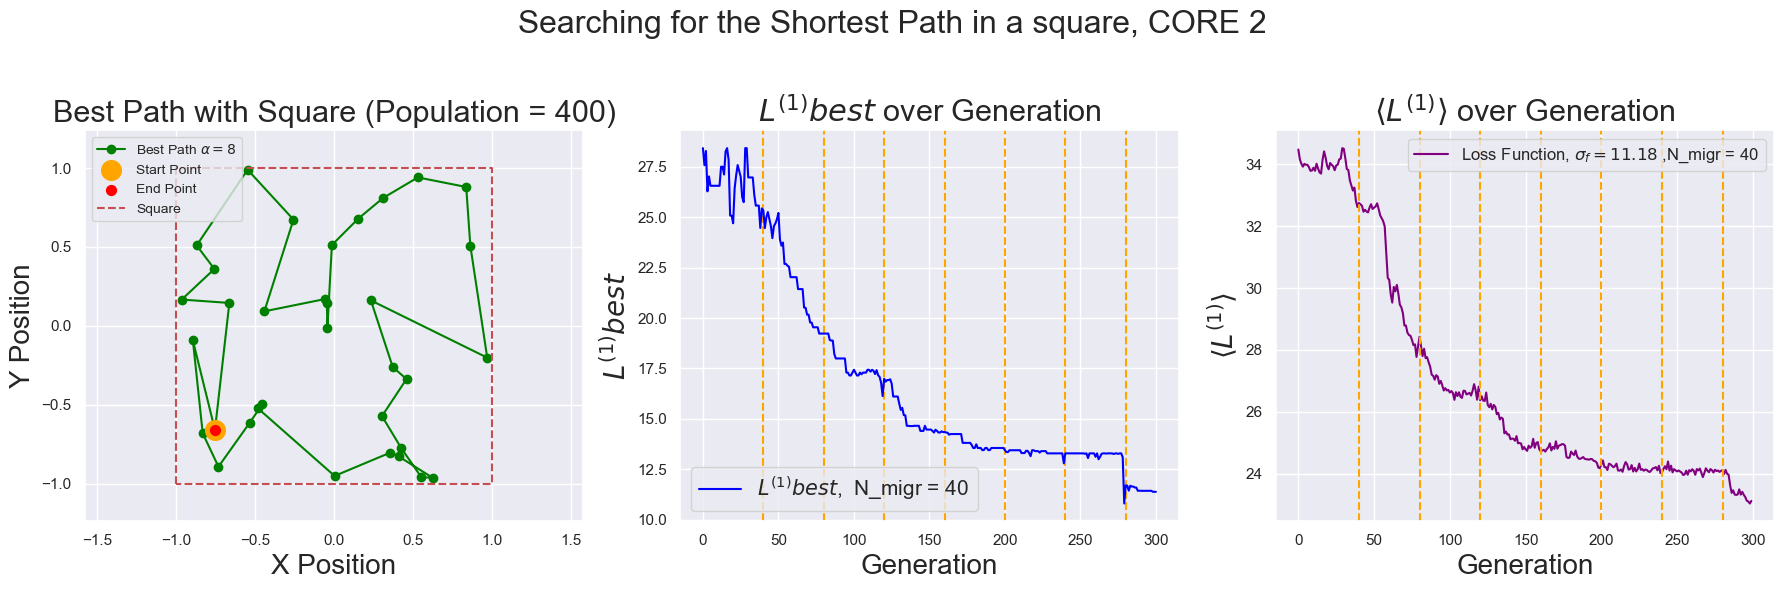

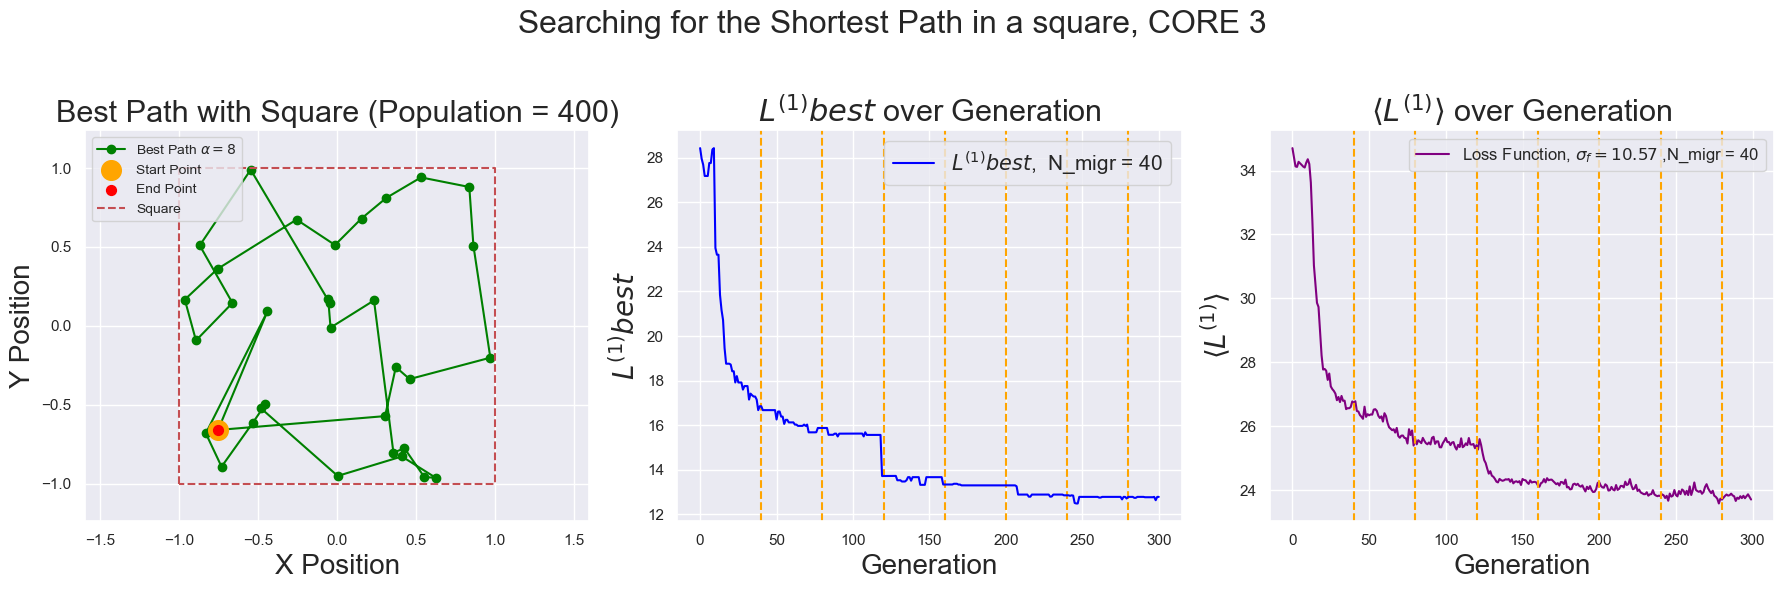

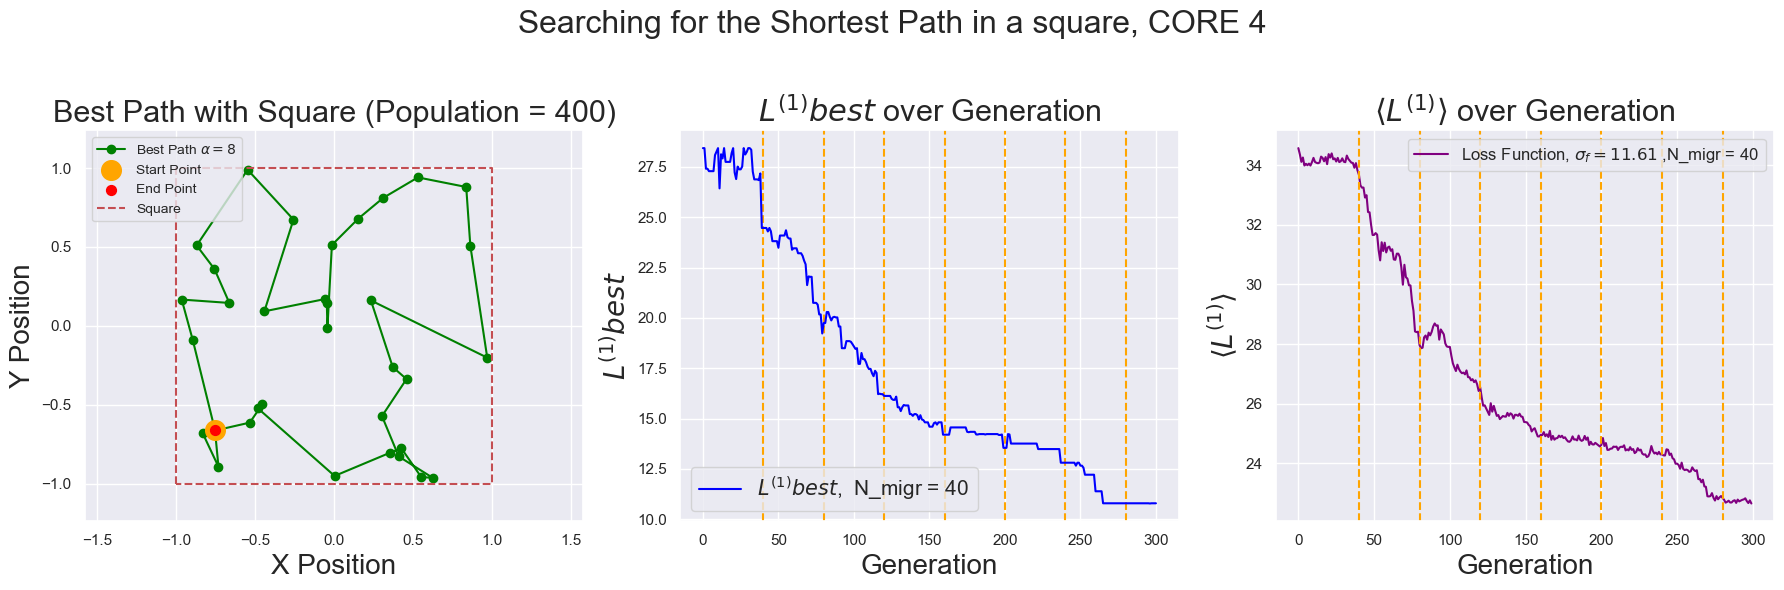

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual theme for the plots
sns.set_theme(style='darkgrid')

# Loop over n from 0 to 4
for n in range(5):
    # 1. Load the positions from the 'best_path_square_n_.dat' file
    file_path_positions = f'./Esercizio_10_1/OUTPUT/best_path_square_{n}_.dat'
    data_positions = np.loadtxt(file_path_positions, skiprows=1)  # Assuming two columns (X, Y)
    x_positions = data_positions[:, 0]
    y_positions = data_positions[:, 1]

    # 2. Load the loss function values from the 'Loss_media_square_best_n_.dat' file
    file_path_loss = f'./Esercizio_10_1/OUTPUT/Loss_media_square_best_{n}_.dat'
    data_loss = np.loadtxt(file_path_loss, skiprows=1)

    # Separate the columns: first column for plotting, last value of the second column for dev_std_best
    loss_values = data_loss[:, 0]  # Take only the first column for plotting
    dev_std_best = data_loss[-1, 1]  # Take the last value of the second column

    # 3. Load the single loss function values from 'Loss_media_square_best_{n}_single.dat' file
    file_path_loss_single = f'./Esercizio_10_1/OUTPUT/Loss_media_square_best_{n}_single.dat'
    loss_single_values = np.loadtxt(file_path_loss_single, skiprows=1)

    # 4. Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Searching for the Shortest Path in a square, CORE {n}", fontsize=23)

    # 4.1 Plot the best path in the first subplot
    axs[0].plot(x_positions, y_positions, marker='o', linestyle='-', color='green', label=r'Best Path $\alpha = 8 $')
    axs[0].scatter(x_positions[0], y_positions[0], color='orange', s=200, zorder=5, label='Start Point')
    axs[0].scatter(x_positions[-1], y_positions[-1], color='red', s=50, zorder=5, label='End Point')

    # Draw a square centered at (0,0) with side length 1
    side_length = 1
    half_side = side_length
    square_x = np.array([-half_side, -half_side, half_side, half_side, -half_side])  
    square_y = np.array([-half_side, half_side, half_side, -half_side, -half_side])  # y-coordinates of the square corners
    axs[0].plot(square_x, square_y, color='r', linestyle='--', label='Square')

    # Customize the first subplot
    axs[0].set_title(f"Best Path with Square (Population = 400)", fontsize=22)
    axs[0].set_xlabel("X Position", fontsize=20)
    axs[0].set_ylabel("Y Position", fontsize=20)
    axs[0].legend(loc=2, fontsize=10)
    axs[0].grid(True)
    axs[0].axis('equal')  # Maintain aspect ratio

    # 4.2 Plot the loss function in the second subplot
    axs[2].plot(loss_values, color='purple', label=f'Loss Function, $\sigma_f = {np.round(dev_std_best,2)}$ ,N_migr = 40')
    axs[2].set_title(r"$\langle L^{(1)} \rangle$ over Generation", fontsize=22)
    axs[2].set_xlabel("Generation", fontsize=20)
    axs[2].set_ylabel(r"$\langle L^{(1)} \rangle$", fontsize=20)
    axs[2].legend(loc= 1,fontsize =12)
    axs[2].grid(True)

    # Add vertical dashed lines for multiples of 40 in the loss function plot
    for generation in range(40, len(loss_values), 40):
        axs[1].axvline(x=generation, color='orange', linestyle='--')  # Only label the first line
        axs[2].axvline(x=generation, color='orange', linestyle='--')  # Only label the first line
    # 4.3 Plot the single loss function in the third subplot
    
    axs[1].plot(loss_single_values, color='blue', label=r'$L^{(1)} best$,  N_migr = 40')
    axs[1].set_title(r'$L^{(1)} best$ over Generation', fontsize=22)
    axs[1].set_xlabel("Generation", fontsize=20)
    axs[1].set_ylabel(r'$L^{(1)} best$', fontsize=20)
    axs[1].legend(fontsize =15)
    axs[1].grid(True)

    # Display the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the global title
    plt.show()


## Discussion and Observation:
For each shape, convergence is achieved as in Exercise 9. Specifically, by convergence in the first case, I mean that the path fully aligns with the circumference; in the second case, convergence means that the path is complete, minimizing intersections. 

Two aspects are particularly interesting:
The first is that for cities on a circumference and inside a square, convergence is not achieved for every core, as might be expected. As in Exercise 9, convergence was observed to depend significantly on the parameter $\alpha$, population size,number of generation ,and the probabilities of mutation and crossover. However, it could also be influenced by the pseudo-random data generated by the random generator, suggesting a dependency on the seed primers.

In this context, it's interesting to observe that for the circumference, *CORE 0* achieves convergence, having the same primers as in Exercise 9, as well as convergence in *COREs 1* and *3*. In contrast, for the square, *CORE 0* does not converge, but *COREs 2* and *4* do. In this latter square case, the migration operation seems to have impacted *CORE 0*, influencing its path calculations.

The second noteworthy aspect is the variation in the best loss function. As observed in the previous lesson, the genetic algorithm demonstrates considerable effectiveness in reducing the loss function significantly during the early generations. However, it often encounters challenges in finding the absolute minimum path, likely due to local minima. Additionally, the value of $\langle L^{(1)} \rangle$ for cities arranged in a square does not exactly match the value of the best $L^{(1)}$. This discrepancy arises because the average is calculated over the top half of the population. As the population size increases, the mean value may deviate from the convergence mean value, although with the values of $\sigma_f$ remain compatible.
Looking to Loss Best $L^{(1)}$, specially in square city, is there the same observation made for `Esecizio_9_1` taking in consideration a little flaw in selection method.

Another observation is could be done analyzing the loss function behaviour, step-like changes typically indicate the selection of a new population and an efficient mutation or crossover operation. For some steps, it is notable that a migration event coincides with the change, suggesting an influence from the new implementation, as observed on *CORE 1* for square cities during the first migration. Conversely, in other cases, such as the first migration on *CORE 2* for square cities, there may be a worsening effect, though other factors could also contribute. 

For this reason, in the following exercise, the path and setup will change, and graphs will compare the quality and efficiency of the search between independent core processing and the use of parallelization with migration.



### Exercise 10.2

Apply your parallel code to the TSP problem for 110 italian "capoluoghi di provincia" longitude and latitude coordinates in the *cap_prov_ita.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

## Improvement of the code:

In this code, compared to the previous one, two simple changes have been made while the rest remains unchanged:
The first is reading data from `./INPUT/prov_ita.txt` for Italian province labels and `./INPUT/cap_prov_ita.dat` for the respective coordinates. Due to these additions, the file `./INPUT/input.dat` has been simplified to contain only the population settings.
Additionally, the migration implementation has been modified for cases where `N_migr ≠ 0`.
Other aspects remain unchanged.

### Data Setting:
For this setting, `N_migr = 90`, with a population size of `1300` and `900` generations, along with $\alpha = 21$, a mutation probability of $4.5\%$, and a cross-over probability of $81\%$.

In this case, the population size, number of generations, and alpha value have been significantly increased to provide a wider range of possible paths for finding the minimum, as the number of points to connect has grown from `34` in the previous task to `110`. Additionally, the increased alpha favors paths with a lower loss function.

This data is saved in files named `./Esercizio_10_2/OUTPUT/Path_italy_best_{n}_no_migration_.dat`, `./Esercizio_10_2/OUTPUT/Path_italy_best_{n}_.dat` and for the loss function `./Esercizio_10_2/OUTPUT/Loss_media_italy_best_{n}_.dat` and
`./Esercizio_10_2/OUTPUT/Loss_media_italy_best_{n}_no_migration_.dat`where `n` is the core number.

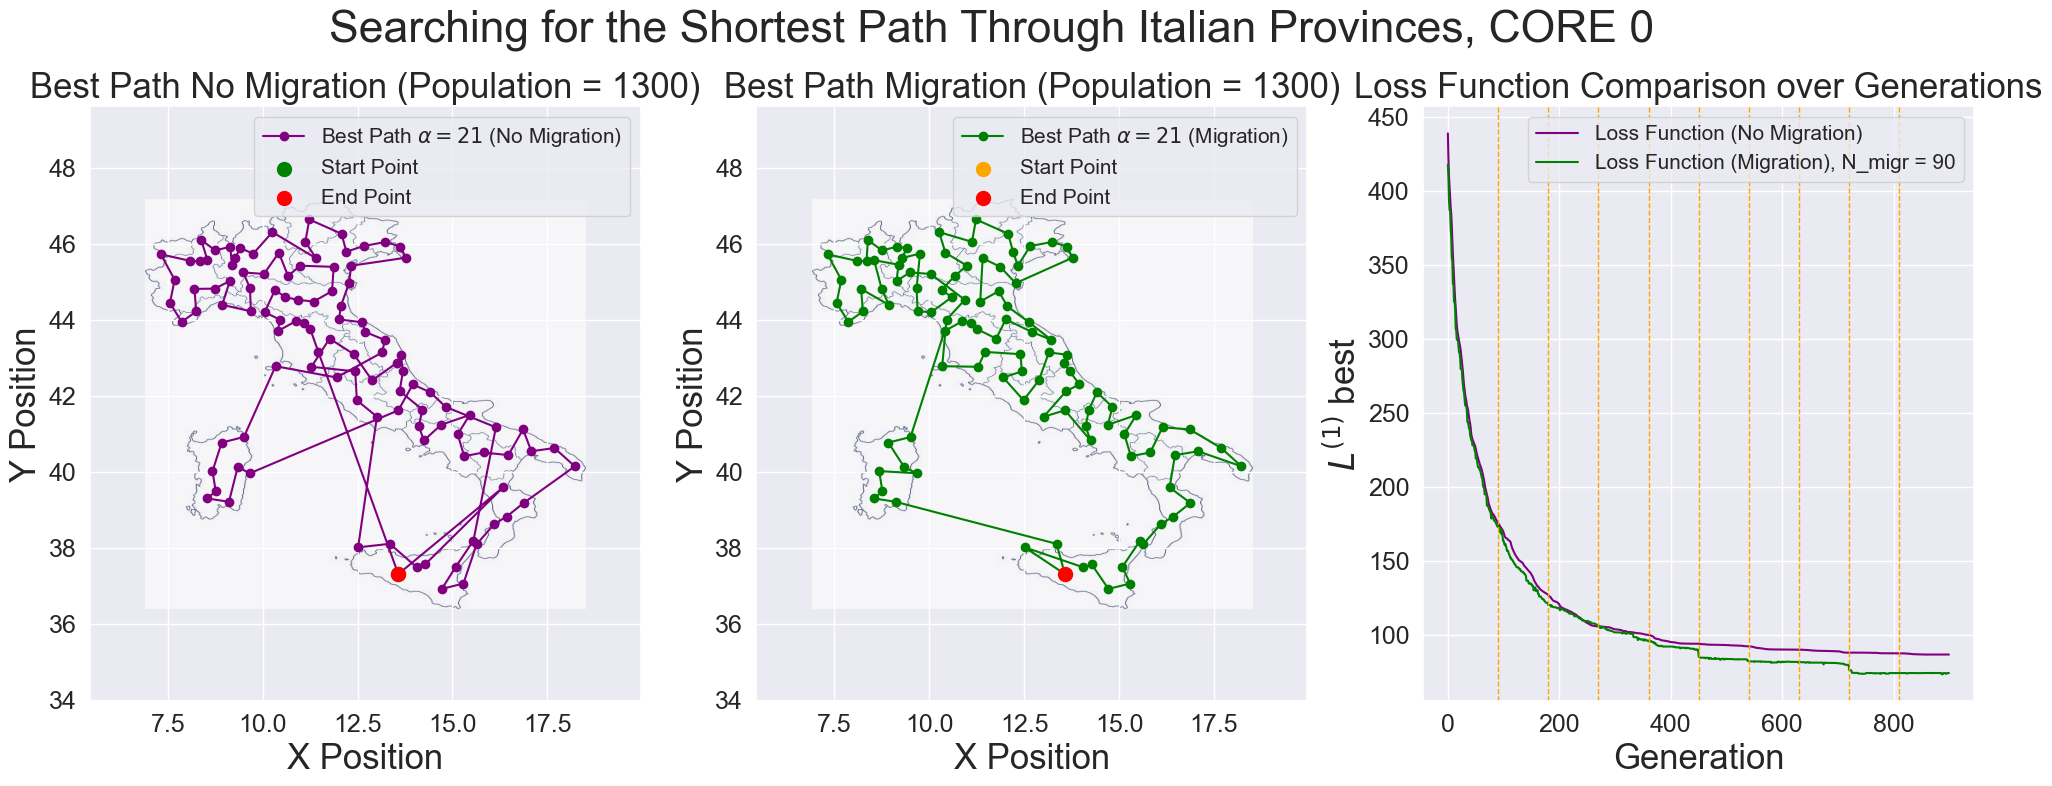

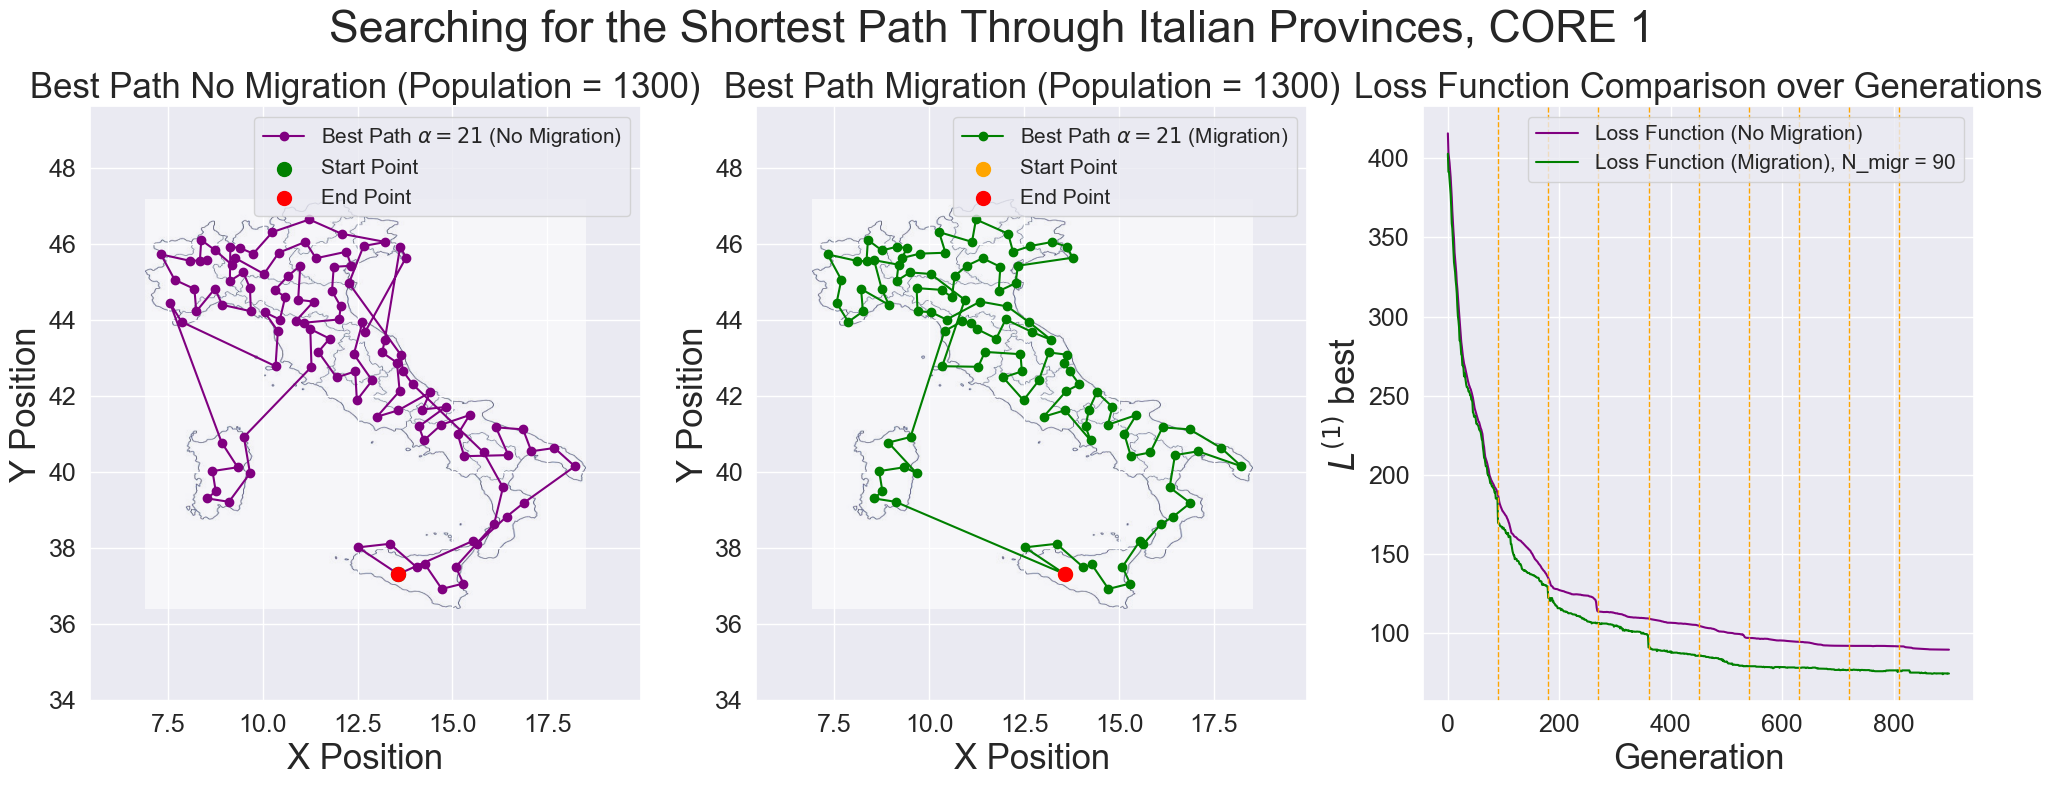

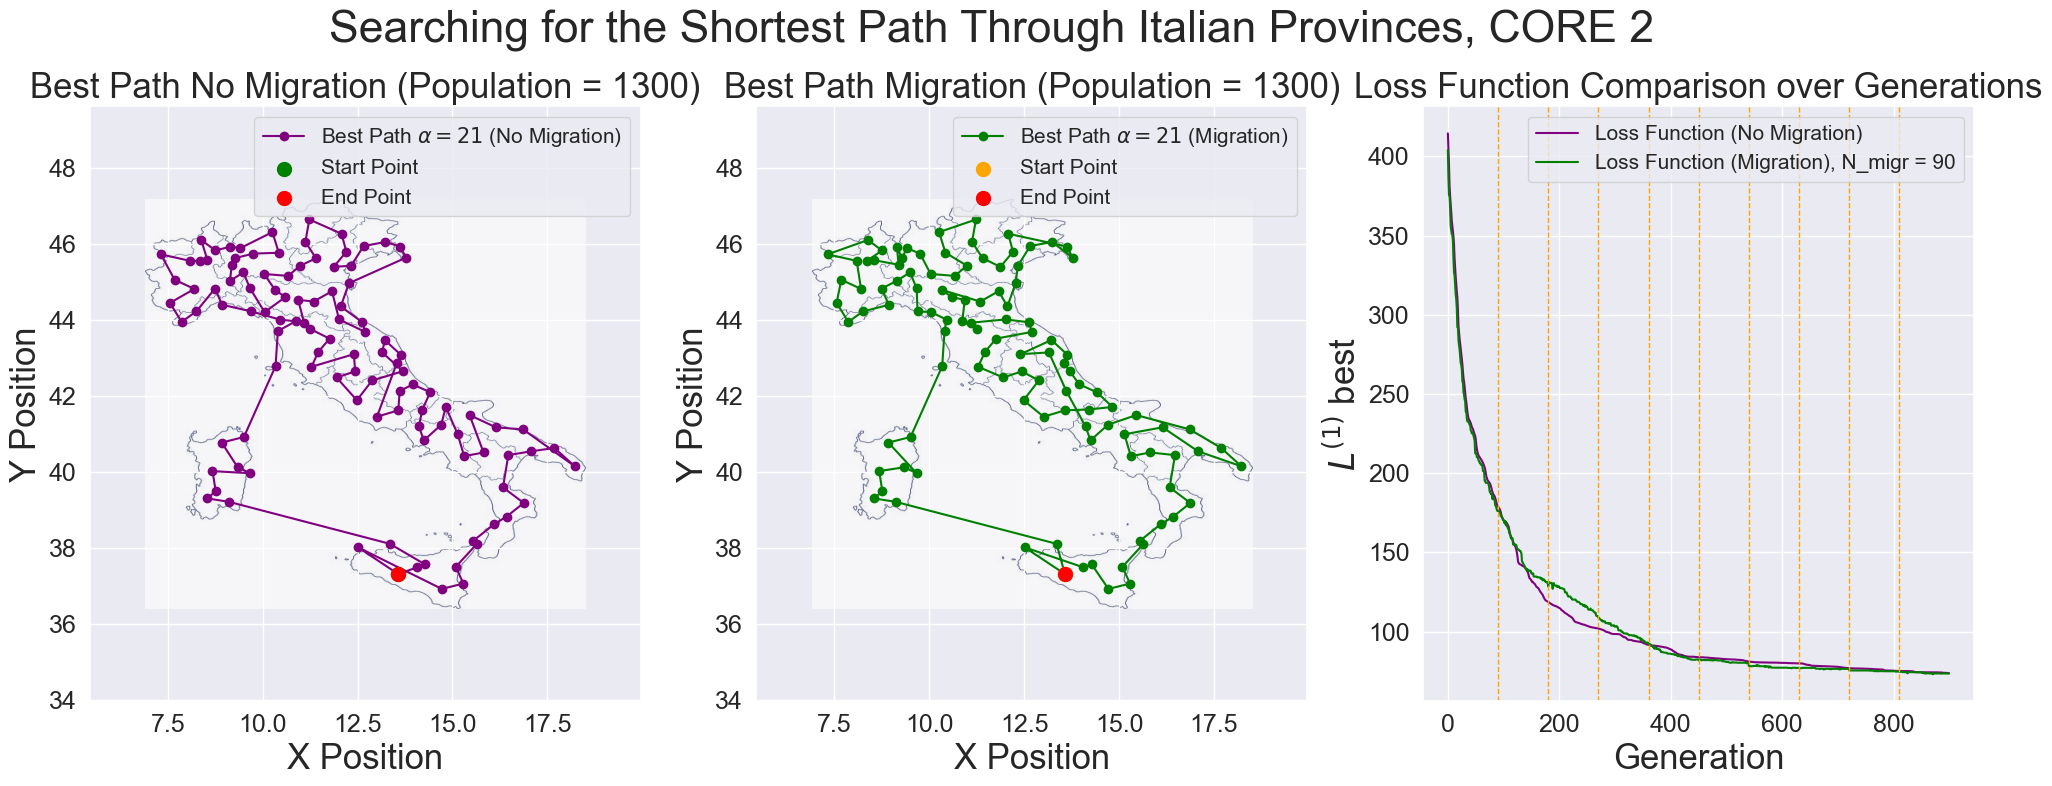

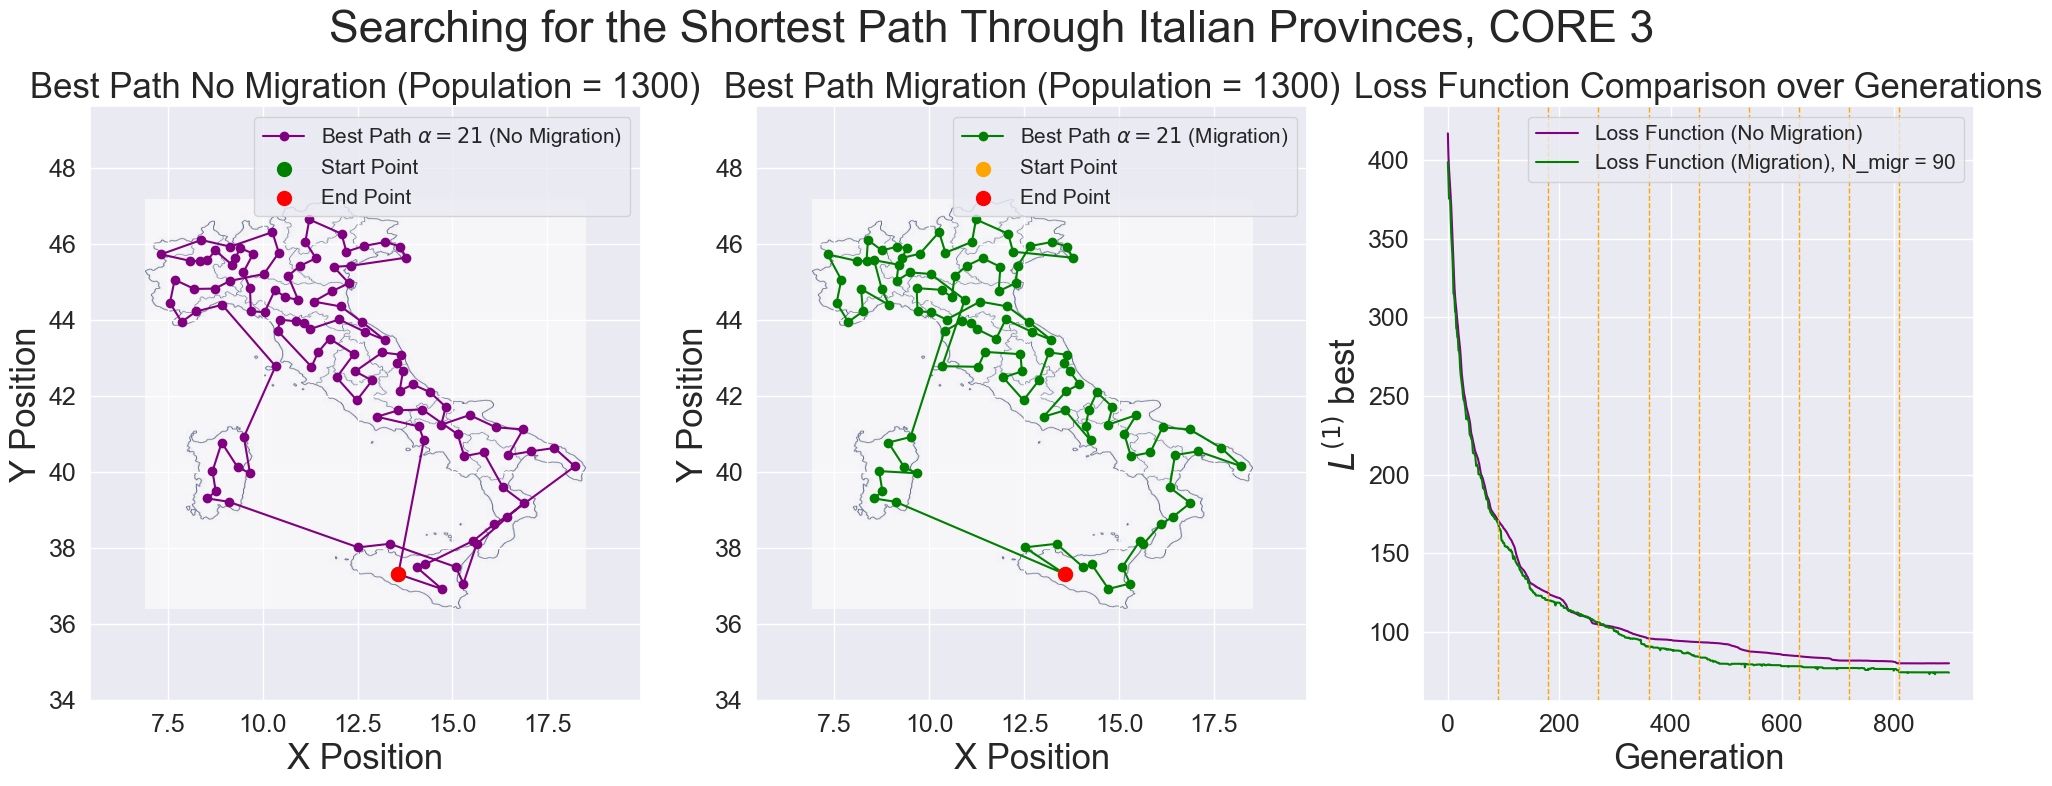

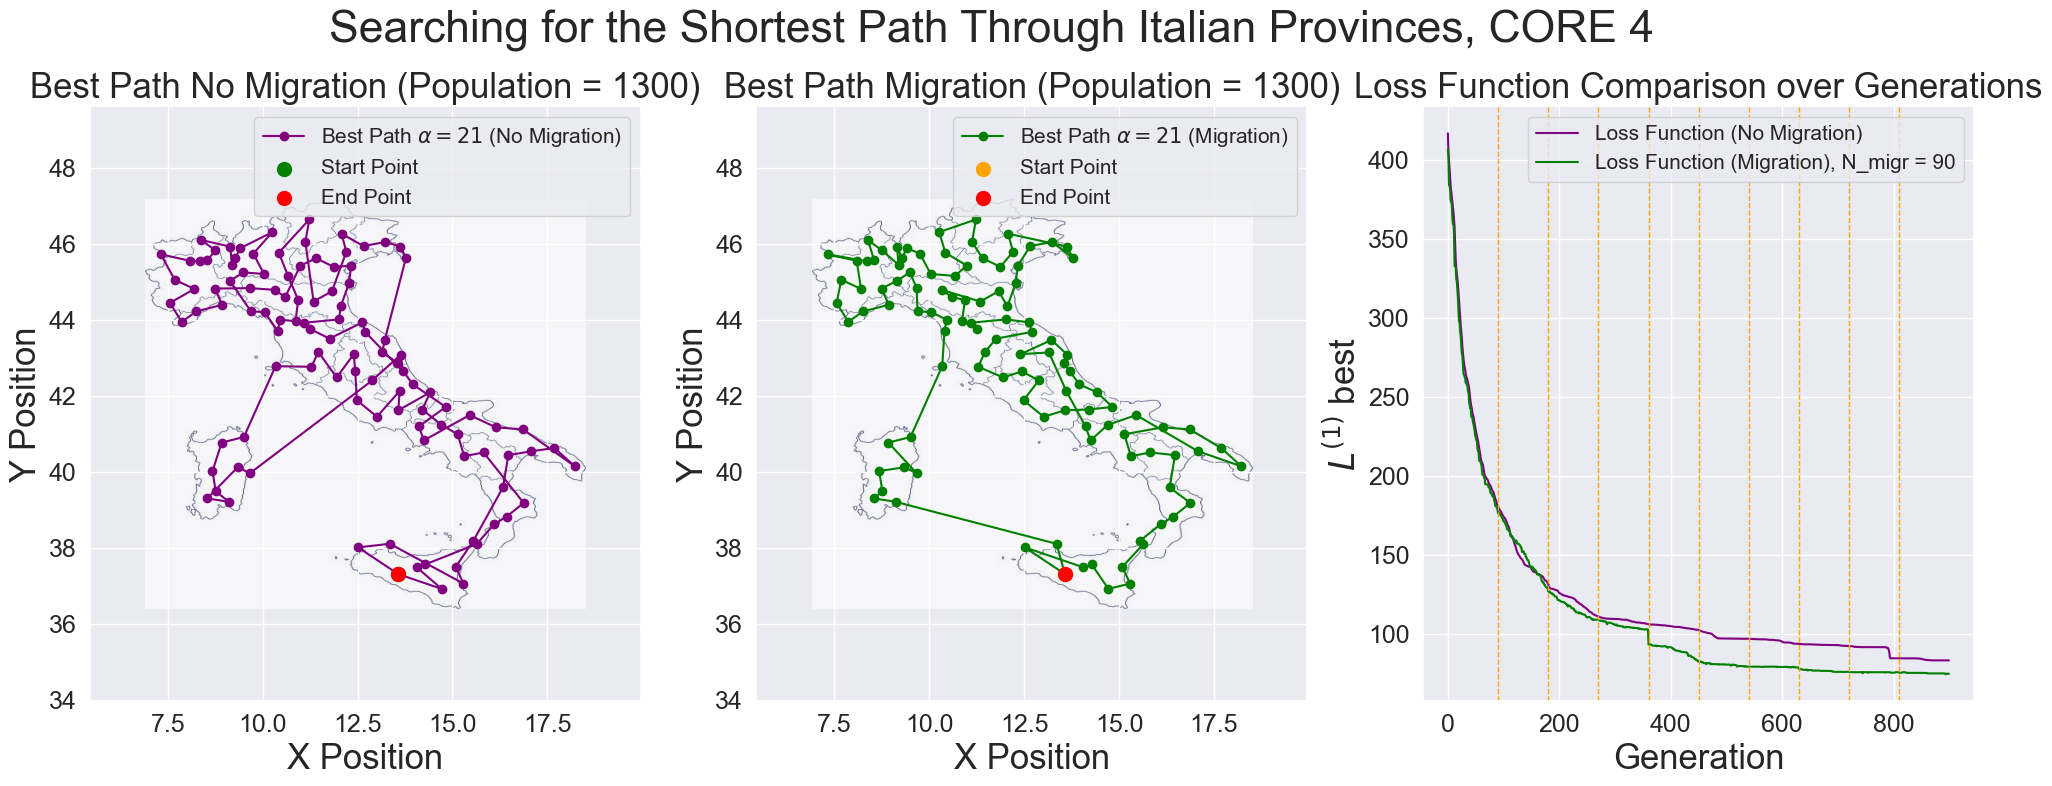

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Set the visual theme for the plots
sns.set_theme(style='darkgrid')

# Carica l'immagine della sagoma dell'Italia
italy_map_img = plt.imread('italy_map.jpg')
scale_factor = 10

# Loop over n from 0 to 4
for n in range(5):
    # 1. Load the positions from the 'Path_italy_best_{n}_no_migration_.dat' file
    file_path_positions_no_migration = f'./Esercizio_10_2/OUTPUT/Path_italy_best_{n}_no_migration_.dat'
    data_positions_no_migration = np.loadtxt(file_path_positions_no_migration, skiprows=1)
    x_positions_no_migration = data_positions_no_migration[:, 0]
    y_positions_no_migration = data_positions_no_migration[:, 1]

    # 2. Load the positions from the 'Path_italy_best_{n}_.dat' file
    file_path_positions_migration = f'./Esercizio_10_2/OUTPUT/Path_italy_best_{n}_.dat'
    data_positions_migration = np.loadtxt(file_path_positions_migration, skiprows=1)
    x_positions_migration = data_positions_migration[:, 0]
    y_positions_migration = data_positions_migration[:, 1]

    # 3. Load the loss function values from the files for comparison
    file_path_loss_no_migration = f'./Esercizio_10_2/OUTPUT/Loss_media_italy_best_{n}_no_migration_.dat'
    loss_values_no_migration = np.loadtxt(file_path_loss_no_migration, skiprows=1)

    file_path_loss_migration = f'./Esercizio_10_2/OUTPUT/Loss_media_italy_best_{n}_.dat'
    loss_values_migration = np.loadtxt(file_path_loss_migration, skiprows=1)

    # 4. Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    fig.suptitle(f"Searching for the Shortest Path Through Italian Provinces, CORE {n}", fontsize=32)
    
    # Define custom limits to zoom in on the Italy map
    x_min, x_max = 6.9, 18.5  # Adjust x-axis limits to focus on Italy
    y_min, y_max = 36.4,  47.2  # Adjust y-axis limits to focus on Italy

    extent=[x_min, x_max, y_min, y_max]

    # 4.1 Plot the best path without migration in the first subplot
    axs[0].imshow(italy_map_img, extent=extent, aspect='auto', alpha=0.6)
    axs[0].plot(x_positions_no_migration, y_positions_no_migration, marker='o', linestyle='-', color='purple', label=r'Best Path $\alpha = 21 $ (No Migration)')
    axs[0].scatter(x_positions_no_migration[0], y_positions_no_migration[0], color='green', s=100, zorder=5, label='Start Point')
    axs[0].scatter(x_positions_no_migration[-1], y_positions_no_migration[-1], color='red', s=100, zorder=5, label='End Point')
    axs[0].set_title(f"Best Path No Migration (Population = 1300)", fontsize=25)
    axs[0].set_xlabel("X Position", fontsize=25)
    axs[0].set_ylabel("Y Position", fontsize=25)
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[0].legend(loc=1, fontsize=15)
    axs[0].grid(True)
    axs[0].axis('equal')  # Maintain aspect ratio

    # 4.2 Plot the best path with migration in the second subplot
    axs[1].imshow(italy_map_img, extent=extent, aspect='auto', alpha=0.6)
    axs[1].plot(x_positions_migration, y_positions_migration, marker='o', linestyle='-', color='green', label=r'Best Path $\alpha = 21 $ (Migration)')
    axs[1].scatter(x_positions_migration[0], y_positions_migration[0], color='orange', s=100, zorder=5, label='Start Point')
    axs[1].scatter(x_positions_migration[-1], y_positions_migration[-1], color='red', s=100, zorder=5, label='End Point')
    axs[1].set_title("Best Path Migration (Population = 1300)", fontsize=25)
    axs[1].set_xlabel("X Position", fontsize=25)
    axs[1].set_ylabel("Y Position", fontsize=25)
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    axs[1].legend(loc=1, fontsize=15)
    axs[1].grid(True)
    axs[1].axis('equal')  # Maintain aspect ratio

    # 4.3 Plot the loss function comparison in the third subplot
    axs[2].plot(loss_values_no_migration, color='purple', label='Loss Function (No Migration)')
    axs[2].plot(loss_values_migration, color='green', label='Loss Function (Migration), N_migr = 90')
    axs[2].set_title("Loss Function Comparison over Generations", fontsize=25)
    axs[2].set_xlabel("Generation", fontsize=25)
    axs[2].set_ylabel("$L^{(1)}$ best", fontsize=25)
    axs[2].legend(fontsize=15)
    axs[2].grid(True)
    
    # Aggiungi linee verticali tratteggiate ogni 90 generazioni
    for generation in range(90, len(loss_values_no_migration), 90):
        axs[2].axvline(x=generation, color='orange', linestyle='--', linewidth=1)

    # Ingrandisci i numeri degli assi x e y
    axs[0].tick_params(axis='both', which='major', labelsize=18)
    axs[1].tick_params(axis='both', which='major', labelsize=18)
    axs[2].tick_params(axis='both', which='major', labelsize=18)

    # 5. Show the figure
    plt.tight_layout()
    plt.show()


## Discussion and Observations:

The observations on the convergence of the parallelized code are very similar to those in Exercise 10.1. 
From the loss function graphs, we can see there is little difference in efficiency between the methods with and without migration. An interesting case is CORE 2, as seen from the files `./Esercizio_10_2/OUTPUT/output_italy_best_.dat` and `./Esercizio_10_2/OUTPUT/output_italy_best_no_migration_.dat`, which shows the best convergence. In the loss function graph of this core, we can see two different paths taken between roughly the 150th and 400th generations, but they reach the same endpoint. This behavior does not occur in the other cores, where we can also observe that the loss function with migration is generally higher than without migration.

### Observations on Exercise 10 and the GA Algorithm:

This exercise provided insights into the functioning of genetic algorithms when implemented with code parallelization. First, as noted in previous exercises, we can observe the strength of genetic algorithms in efficiently finding the minimum of the loss function, particularly in the early generations, significantly reducing the loss function. However, they also struggle with the tendency to converge to absolute local minima. Additionally, as the number of "cities" to connect increases, it becomes necessary to raise the population size, the number of generations, and the alpha value.

In terms of parallelization, this approach enhanced process efficiency and facilitated communication between cores, leading to a broader spectrum of data obtained simultaneously. This allowed for multiple concurrent simulations, with slight improvements observed when inter-process communication was utilized.

